## BERT for English and Spanish text
- BERT (Bidirectional Encoder Representations from Transformers) predicts the sentiment of a sentence by looking at the whole sentence, unlike NLTK which pays attention to singular tokens in a sentence. It can understand how each word affects the sentence, and how this changes the sentiment. This way, it is also influenced by by the feelings in the sentence like sarcasm or negation, and hence our speculation that it's more accurate than NLTK
- After being fine-tuned on our data, BERT predicts the label of the sentiment of the sentence, rather than giving a sentiment score like NLTK. So we wouldn't need to create a scale for the labels.
- It uses a next word prediction algorithm, similar to that of chatGPT, by encoding 15% of the sentences and adding noise, and learning how to decode it via the training process. 
- We used a pre-trained model from hugging face called bert base uncased. It was pre-trained on english text in a supervised manner and is not affected by the casing of the tokens, i.e, 'Word' is considered the same as 'word'. 

In [1]:
import os
import shutil
import tarfile
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertForSequenceClassification

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Not required but useful
from transformers import logging
logging.set_verbosity_error()

from tqdm.notebook import tqdm
tqdm.pandas()

2024-03-14 03:52:34.131987: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [1]:
#!pip install transformers


# Data Cleaning

In [3]:
df = pd.read_csv('IMDB Dataset SPANISH.csv', encoding='utf8')
df = df[['review_en', 'review_es', 'sentiment']]

In [4]:
df.head()

,review_en,review_es,sentiment
0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive
1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive
2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive
3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive


In [5]:
# Change sample size here
train_n = 5000
test_n = 5000

In [6]:
# Splits data between train(60%) and test(40%)
random.seed(42)

train_df = df.sample(train_n, random_state=42) #df[['review_en', 'sentiment', 'review_es']].iloc[train_indices]
test_df = (df[~df.isin(train_df)].dropna()).sample(test_n, random_state=42) #[['review_en', 'sentiment', 'review_es']].iloc[test_indices]

## Sentiment Analysis: English

In [8]:
# Splits train between train(40%) and validation(20%)
x_train_eng, x_val_eng, y_train_eng, y_val_eng = train_test_split(
                                                    train_df['review_en'],
                                                    train_df['sentiment'],
                                                    test_size=0.25,
                                                    stratify = train_df['sentiment'],
                                                    random_state=42
                                                )

In [9]:
# Tokenizes and encodes the sentences for training
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
max_len= 128

X_train_encoded_eng = tokenizer.batch_encode_plus(x_train_eng.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_val_encoded_eng = tokenizer.batch_encode_plus(x_val_eng.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

2024-03-14 03:52:54.546847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10174 MB memory:  -> device: 0, name: NVIDIA A30 MIG 2g.12gb, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [10]:
# Gets model and fine-tunes
LEARNING_RATE = 5e-5

model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=[metric])

In [11]:
# Cleans datasets for model fitting
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train_encoded_eng),
    y_train_eng.apply(lambda x: True if x=='positive' else False)
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_val_encoded_eng),
    y_val_eng.apply(lambda x: True if x=='positive' else False)
))


- Epoch = total number of training iterations
- We used 4 as we observed that training loss was decreasing but the validation loss stopped at the 4th epoch.

In [12]:
# Fits model based on data
history = model.fit(train_dataset.batch(16),
              epochs=4,
              batch_size=16,
              validation_data=test_dataset.batch(16))

Epoch 1/4
  1/235 [..............................] - ETA: 53:28 - loss: 0.6893 - accuracy: 0.4375

2024-03-14 03:53:13.172169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


235/235 [==============================] - 55s 176ms/step - loss: 0.4462 - accuracy: 0.7824 - val_loss: 0.3863 - val_accuracy: 0.8184
Epoch 2/4
235/235 [==============================] - 39s 167ms/step - loss: 0.2269 - accuracy: 0.9123 - val_loss: 0.4606 - val_accuracy: 0.8264
Epoch 3/4
235/235 [==============================] - 39s 168ms/step - loss: 0.1318 - accuracy: 0.9539 - val_loss: 0.8067 - val_accuracy: 0.7736
Epoch 4/4
235/235 [==============================] - 39s 168ms/step - loss: 0.1184 - accuracy: 0.9573 - val_loss: 0.5121 - val_accuracy: 0.8400


In [14]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [15]:
print(history_dict)

{'loss': [0.44616207480430603, 0.22691364586353302, 0.13184481859207153, 0.11838480830192566], 'accuracy': [0.7824000120162964, 0.9122666716575623, 0.9538666605949402, 0.9573333263397217], 'val_loss': [0.3863130211830139, 0.4606159031391144, 0.8067473769187927, 0.5120529532432556], 'val_accuracy': [0.8184000253677368, 0.8263999819755554, 0.7735999822616577, 0.8399999737739563]}


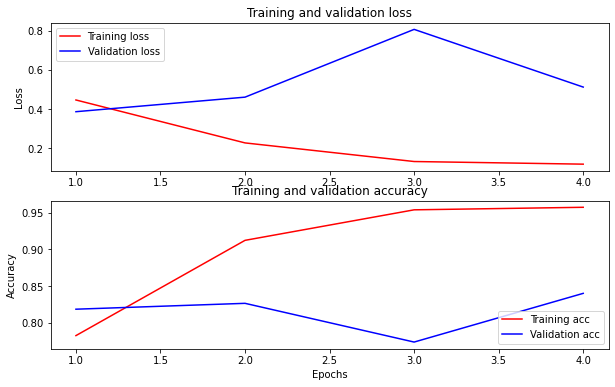

In [16]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [19]:
# Predicts sentiment based on model
def predict(test_sentence):
    pred_input = tokenizer.encode(
        test_sentence,
        truncation=True,
        padding=True,
        return_tensors="tf"
    )

    tf_output = model.predict(pred_input, verbose=False)[0]
    tf_prediction = tf.nn.softmax(tf_output, axis=1)
    labels = ['negative','positive'] #(0:negative, 1:positive)
    label = tf.argmax(tf_prediction, axis=1)
    label = label.numpy()
    return labels[label[0]]

test_sentence = 'What a lovely and beautiful day'
predict(test_sentence)

'positive'

In [20]:
# Gets BERT sentiment and accuracy
test_df['bert_en_sentiment'] = test_df['review_en'].progress_apply(predict)
test_df.query('sentiment == bert_en_sentiment').shape[0]/test_df.shape[0]

  0%|          | 0/5000 [00:00<?, ?it/s]

0.8872

In [21]:
test_df

,review_en,review_es,sentiment,bert_en_sentiment
42187,I had high hopes when I went into the theatre-...,Tenía grandes esperanzas cuando entré en el te...,negative,negative
10971,Black Day Blue Night was actually good modern ...,La noche azul del día negro fue en realidad un...,positive,positive
48213,*THIS REVIEW MAY CONTAIN SPOILERS... OR MAYBE ...,* Esta revisión puede contener spoilers ... o ...,negative,negative
15325,Despite the mysteriously positive reviews and ...,A pesar de las críticas misteriosamente positi...,negative,negative
49798,"...""Flight of the Living Dead"" sports producti...","... ""Vuelo de los muertos vivos"" Valores de pr...",negative,negative
...,...,...,...,...
22812,Boogie Nights was without a doubt the best fil...,Boogie Nights fue sin duda la mejor película d...,positive,positive
8422,After watching Tipping the Velvet by Sarah wat...,After watching Tipping the Velvet by Sarah wat...,positive,positive
11356,I caught this movie right in my eye when I was...,Cogí esta película a la derecha en mi ojo cuan...,positive,positive
48106,"""October Sky"" is a film that will steal your h...","""Octubre Sky"" es una película que le robará el...",positive,positive


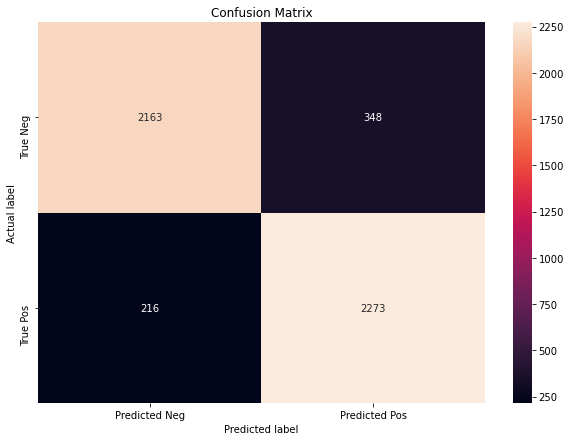

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_df['sentiment'], test_df['bert_en_sentiment'])

conf_matrix_df = pd.DataFrame(conf_matrix, 
                              index=['True Neg', 'True Pos'], 
                              columns=['Predicted Neg', 'Predicted Pos'])

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_df, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [23]:
bert_en_values = []
for i in range(15):
  sampled_df = test_df.sample(n=1000, replace=True)
  sampled_df['bert_en_sentiment'] = sampled_df['review_en'].progress_apply(predict)
  acc = sampled_df.query('sentiment == bert_en_sentiment').shape[0]/sampled_df.shape[0]
  bert_en_values.append(acc)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [24]:
bert_en_values

[0.895,
 0.877,
 0.897,
 0.903,
 0.891,
 0.889,
 0.89,
 0.877,
 0.887,
 0.89,
 0.899,
 0.886,
 0.895,
 0.881,
 0.887]

___